<a href="https://colab.research.google.com/github/sokrypton/ColabBio/blob/main/temp/fig2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attempting at reproducing fig2A from Lauren Porter

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYE' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname test_3b8b0
sequence RKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYE
length 91


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 181 ms, sys: 23.5 ms, total: 204 ms
Wall time: 49.8 s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "alphafold2_ptm" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "1:2" #@param ["1:2", "auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 33 #@param [33,1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

In [5]:
#@title Run Prediction
display_images = False #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

2024-01-08 19:17:07,867 Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2024-01-08 19:17:07,869 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-01-08 19:17:12,107 Running on GPU
2024-01-08 19:17:12,244 Found 5 citations for tools or databases
2024-01-08 19:17:12,245 Query 1/1: test_3b8b0 (length 91)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


2024-01-08 19:17:16,268 Setting max_seq=1, max_extra_seq=2
2024-01-08 19:17:51,437 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=50.8 pTM=0.389
2024-01-08 19:17:52,040 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=51.6 pTM=0.412 tol=1.19
2024-01-08 19:17:52,645 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=55 pTM=0.431 tol=1.29
2024-01-08 19:17:53,245 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=56.7 pTM=0.442 tol=1
2024-01-08 19:17:53,246 alphafold2_ptm_model_1_seed_000 took 25.2s (3 recycles)
2024-01-08 19:17:53,868 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=54 pTM=0.423
2024-01-08 19:17:54,476 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=57.6 pTM=0.475 tol=1.13
2024-01-08 19:17:55,081 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=58.4 pTM=0.491 tol=0.721
2024-01-08 19:17:55,688 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=59.5 pTM=0.505 tol=0.238
2024-01-08 19:17:55,690 alphafold2_ptm_model_2_seed_000 took 2.4s (3 recycles)
2024-01-08 19:17:56,318 alphafold2_pt

0

In [8]:
%%bash
wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp

In [32]:
import numpy as np
import os
def tmscore(x,y):
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

def get_CA_with_bfactor(x):
    xyz = []
    b_factors = []
    with open(x, "r") as file:
        for line in file:
            line = line.rstrip()
            if line[:4] == "ATOM":
                atom = line[12:16].strip()
                if atom == "CA":
                    resi = line[17:20].strip()
                    resn = int(line[22:26])
                    x_coord = float(line[30:38])
                    y_coord = float(line[38:46])
                    z_coord = float(line[46:54])
                    b_factor = float(line[60:66])

                    xyz.append([x_coord, y_coord, z_coord])
                    b_factors.append(b_factor)

    return np.array(xyz), np.array(b_factors)

In [34]:
data = []
import glob
a,_ = get_CA_with_bfactor("/content/2qkeE.pdb")
b,_ = get_CA_with_bfactor("/content/5jytA.pdb")
for m in range(1,6):
  for s in range(33):
    pdb_filename = f"/content/test_3b8b0/test_3b8b0_unrelaxed_rank_*_alphafold2_ptm_model_{m}_seed_{s:03d}.pdb"
    matching_files = glob.glob(pdb_filename)
    ca,bf = get_CA_with_bfactor(matching_files[0])
    to_a = tmscore(a,ca)
    to_b = tmscore(b,ca)
    data.append([to_a["rms"],to_b["rms"],np.mean(bf)])

In [36]:
data_ = np.array(data)
data_.shape

(165, 3)

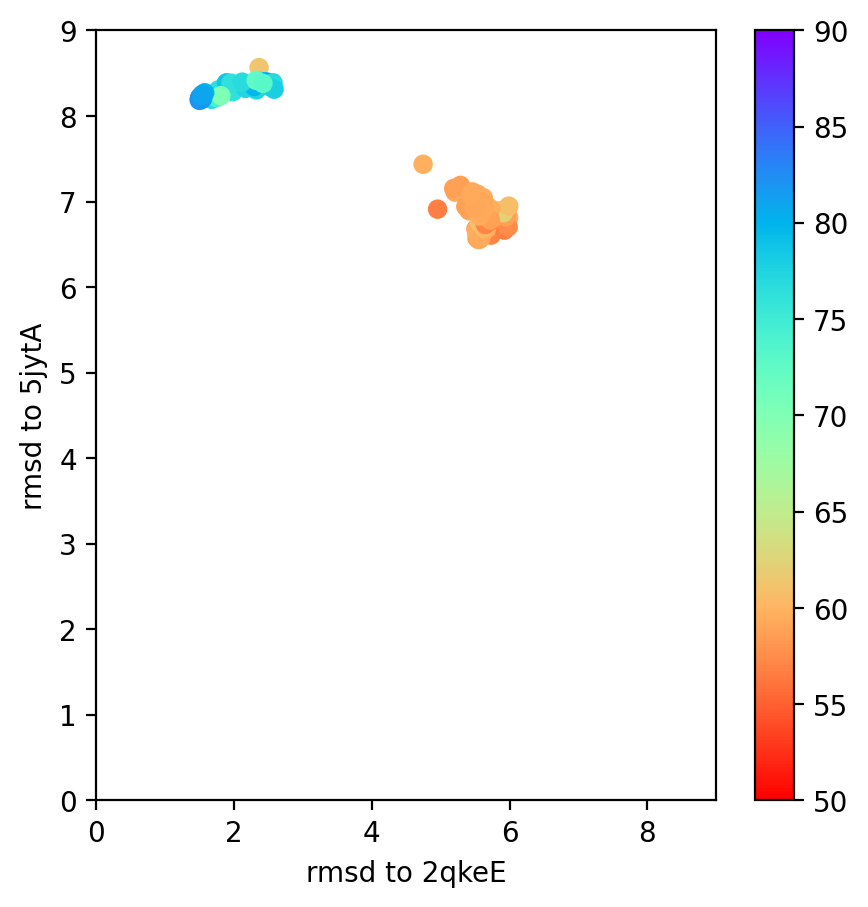

In [41]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(data_[:,0],data_[:,1],c=data_[:,2], cmap="rainbow_r", vmin=50, vmax=90)
plt.xlabel("rmsd to 2qkeE")
plt.ylabel("rmsd to 5jytA")
plt.xlim(0,9)
plt.ylim(0,9)
plt.colorbar()

In [7]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>